# Self RAG

Self-reflection can enhance RAG, enabling correction of poor quality retrieval or generations.

Here we show how to implement self-reflective RAG using `BGE Base`, `Ollama - Mistral`, and `LangGraph`.

We'll focus on ideas from one paper, `Self RAG` [here](https://arxiv.org/abs/2310.11511).

This can run fully locally (e.g., on a laptop).


# Local SELF RAG with LANGGRAPH

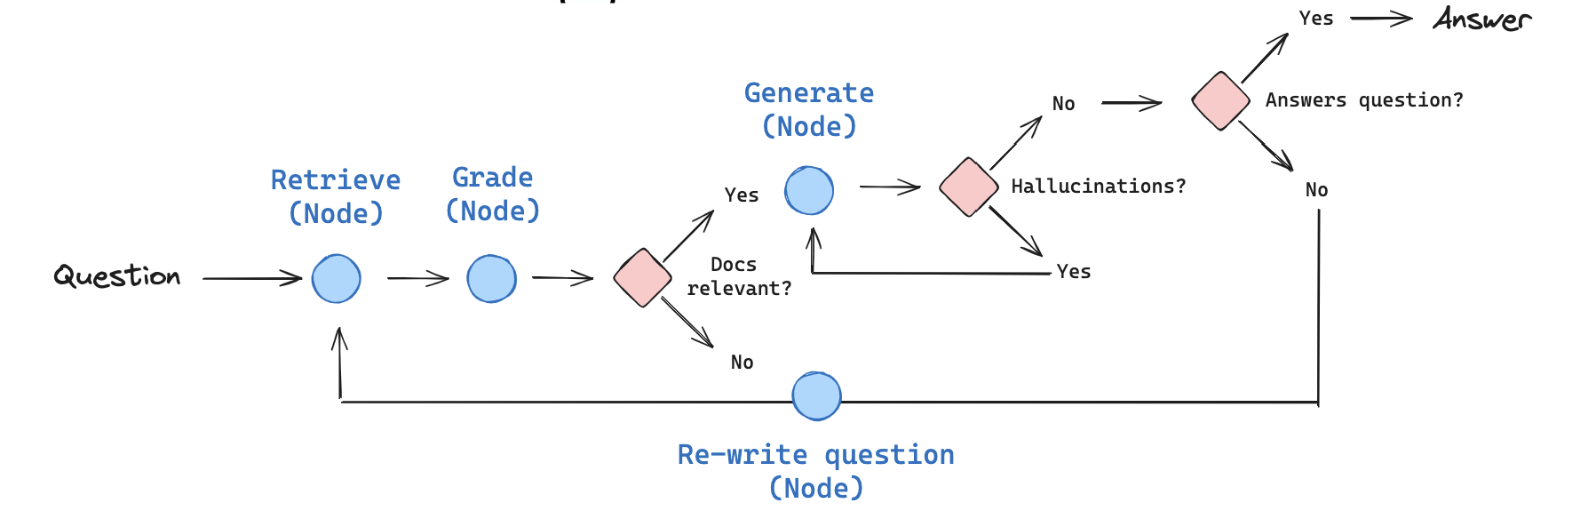


## In this Self-RAG we will implement **RAG TRIAD validation framework**

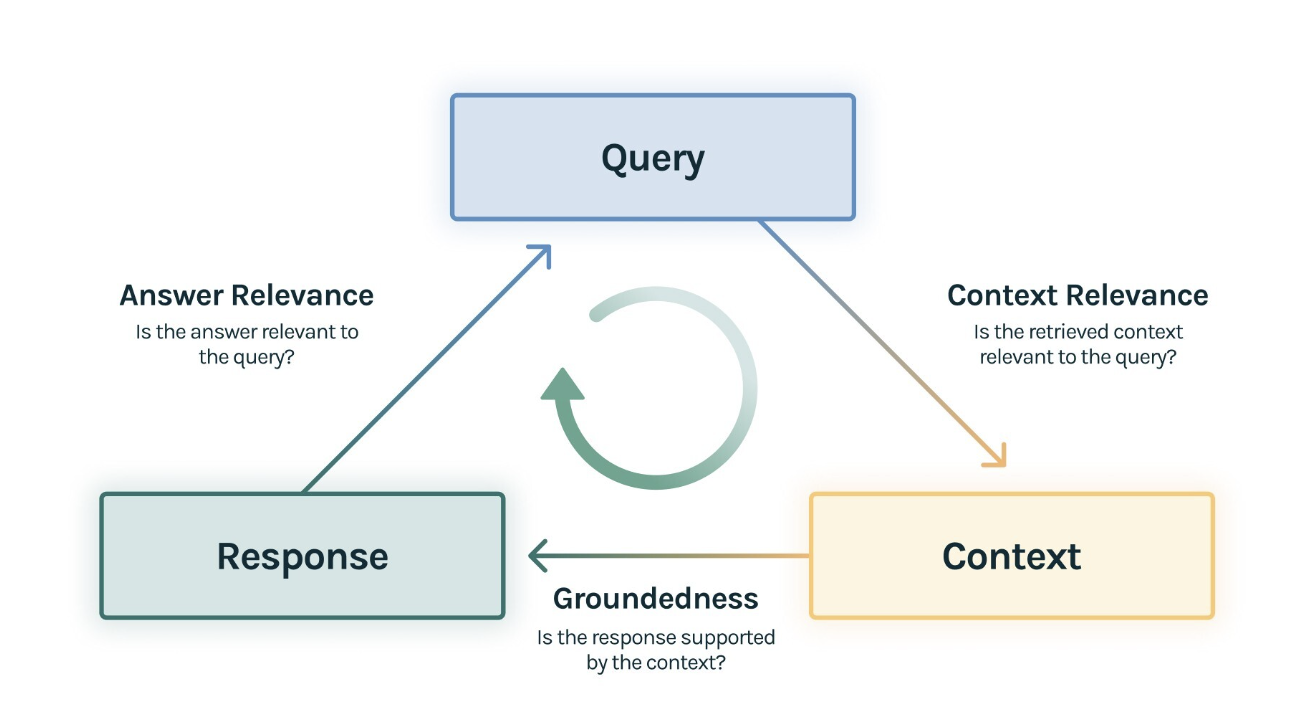


# Install Packages

In [1]:
! pip install -U langchain_community tiktoken langchainhub chromadb langchain langgraph sentence_transformers --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.8.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
boto

In [2]:
!curl -fsSL https://ollama.com/install.sh | sh
!sudo apt install -y neofetch
!neofetch

>>> Downloading ollama...
######################################################################## 100.0%#=#=#                                                                          
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  chafa libchafa0
The following NEW packages will be installed:
  chafa libchafa0 neofetch
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 149 kB of archives.
After this operation, 633 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libchafa0 amd64 1

In [3]:
OLLAMA_MODEL='mistral:instruct'

# Set it at the OS level
import os
os.environ['OLLAMA_MODEL'] = OLLAMA_MODEL
!echo $OLLAMA_MODEL

mistral:instruct


In [4]:
import subprocess
import time

# Start ollama as a backrgound process
command = "nohup ollama serve&"

# Use subprocess.Popen to start the process in the background
process = subprocess.Popen(command,
                            shell=True,
                           stdout=subprocess.PIPE,
                           stderr=subprocess.PIPE)
print("Process ID:", process.pid)
time.sleep(5)

Process ID: 308


In [5]:
!ollama run $OLLAMA_MODEL "Explain AI in one line"

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest 
pulling e8a35b5937a5...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕                ▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕                ▏ 371 KB/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   1% ▕                ▏  45 MB/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   3% ▕       

# Using LangSmith for Tracing

https://smith.langchain.com/

In [6]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = user_secrets.get_secret("Langsmith")
os.environ["LANGCHAIN_PROJECT"] = "Self_RAG_01"

# Download Embedding Model

In [7]:
# Ollama model name
local_llm = OLLAMA_MODEL

from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
embedding = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Indexing

First, let's index a popular blog post on agents. 

We'll use a local vectorstore, [Chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma).

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

# Load
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
loader = WebBaseLoader(url)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=100
)
all_splits = text_splitter.split_documents(docs)

# Index
vectorstore = Chroma.from_documents(
    documents=all_splits,
    collection_name="rag-chroma",
    embedding=embedding,
)
retriever = vectorstore.as_retriever()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## State

Every node in our graph will modify `state`, which is dict that contains values (`question`, `documents`, etc) relevant to RAG.

In [9]:
from typing import Dict, TypedDict

from langchain_core.messages import BaseMessage


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

### Nodes and Edges

Every node in the graph we laid out below is a function.

Each node will modify the state in some way.

Each edge will choose which node to call next.

In [10]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

### Nodes ###


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = retriever.get_relevant_documents(question)
    print(len(documents))
    return {"keys": {"documents": documents, "question": question}}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOllama(model=local_llm, temperature=0)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with relevant documents
    """

    print("---CHECK RELEVANCE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # LLM
    llm = ChatOllama(model=local_llm, format="json", temperature=0)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keywords related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide the binary score as a JSON with a single key 'score' and no premable or explaination.""",
        input_variables=["question","context"],
    )

    # Chain
    chain = prompt | llm | JsonOutputParser()

    # Score
    filtered_docs = []
    for d in documents:
        score = chain.invoke(
            {
                "question": question,
                "context": d.page_content,
            }
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    return {"keys": {"documents": filtered_docs, "question": question}}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # LLM
    llm = ChatOllama(model=local_llm, temperature=0)
    
    # Create a prompt template with format instructions and the query
    prompt = PromptTemplate(
        template="""You are generating questions that is well optimized for retrieval. \n 
        Look at the input and try to reason about the underlying sematic intent / meaning. \n 
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Formulate an improved question:""",
        input_variables=["question"],
    )

    # Chain
    chain = prompt | llm | StrOutputParser()
    better_question = chain.invoke({"question": question})

    return {"keys": {"documents": documents, "question": better_question}}


def prepare_for_final_grade(state):
    """
    Passthrough state for final grade.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): The current graph state
    """

    print("---FINAL GRADE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


### Edges ###


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    filtered_documents = state_dict["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_vs_documents(state):
    """
    Determines whether the generation is grounded in the document.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Binary decision
    """

    print("---GRADE GENERATION vs DOCUMENTS---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    # LLM
    llm = ChatOllama(model=local_llm, format="json", temperature=0)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
        Here are the facts:
        \n ------- \n
        {documents} 
        \n ------- \n
        Here is the answer: {generation}
        Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
        Provide the binary score as a JSON with a single key 'score' and no premable or explaination.""",
        input_variables=["generation", "documents"],
    )

    # Chain
    chain = prompt | llm | JsonOutputParser()
    score = chain.invoke({"generation": generation, "documents": documents})
    grade = score["score"]

    if grade == "yes":
        print("---DECISION: SUPPORTED, MOVE TO FINAL GRADE---")
        return "supported"
    else:
        print("---DECISION: NOT SUPPORTED, GENERATE AGAIN---")
        return "not supported"


def grade_generation_vs_question(state):
    """
    Determines whether the generation addresses the question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Binary decision
    """

    print("---GRADE GENERATION vs QUESTION---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    llm = ChatOllama(model=local_llm, format="json", temperature=0)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
        Here is the answer:
        \n ------- \n
        {generation} 
        \n ------- \n
        Here is the question: {question}
        Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
        Provide the binary score as a JSON with a single key 'score' and no premable or explaination.""",
        input_variables=["generation", "question"],
    )

    # Prompt
    chain = prompt | llm | JsonOutputParser()
    score = chain.invoke({"generation": generation, "question": question})
    grade = score["score"]

    if grade == "yes":
        print("---DECISION: USEFUL---")
        return "useful"
    else:
        print("---DECISION: NOT USEFUL---")
        return "not useful"

## Build Graph for Basic RAG having Retriver and Generation options

In [11]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("generate", generate)  # generatae

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "generate")

workflow.add_edge("generate", END)
# Compile
app1 = workflow.compile()

> ## Basic RAG did not get the answer right

In [12]:
# Run
inputs = {"keys": {"question": "Which technique transforms big tasks into multiple manageable tasks?"}}
for output in app1.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value['keys']['generation'])

---RETRIEVE---


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

4
"Node 'retrieve':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
"Node '__end__':"
'\n---\n'
(' The given text describes the overview of a system that uses a large '
 'language model (LLM) as the brain of an autonomous agent. The system '
 'consists of four stages: task planning, model selection, task execution, and '
 'memory management. In the first stage, LLM parses user requests into '
 'multiple tasks based on their type, dependencies, and arguments. In the '
 'second stage, LLM selects appropriate models for each task from a list of '
 'available models. In the third stage, expert models execute on specific '
 'tasks and log results. The fourth stage is memory management, which stores '
 'and retrieves information as needed.\n'
 '\n'
 'The text also discusses some challenges in building such an agent system, '
 'including finite context length, long-term planning and task decomposition, '
 'and reliability of natural language interface. It concludes with a citation '
 '

## Build Graph - Self RAG with RAG Triad validation framework

This just follows the flow we outlined in the figure above.

In [13]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("prepare_for_final_grade", prepare_for_final_grade)  # passthrough

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_vs_documents,
    {
        "supported": "prepare_for_final_grade",
        "not supported": "generate",
    },
)
workflow.add_conditional_edges(
    "prepare_for_final_grade",
    grade_generation_vs_question,
    {
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

## Run

> ## Self-RAG got the answer Right

In [14]:
# Run
inputs = {"keys": {"question": "Which technique transforms big tasks into multiple manageable tasks?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value['keys']['generation'])

---RETRIEVE---


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

4
"Node 'retrieve':"
'\n---\n'
---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
"Node 'grade_documents':"
'\n---\n'
---DECIDE TO GENERATE---
---DECISION: GENERATE---
---GENERATE---
"Node 'generate':"
'\n---\n'
---GRADE GENERATION vs DOCUMENTS---
---DECISION: SUPPORTED, MOVE TO FINAL GRADE---
---FINAL GRADE---
"Node 'prepare_for_final_grade':"
'\n---\n'
---GRADE GENERATION vs QUESTION---
---DECISION: USEFUL---
"Node '__end__':"
'\n---\n'
(' The techniques for transforming big tasks into multiple manageable tasks '
 'include Task Decomposition using Chain of Thought or Tree of Thoughts. These '
 'methods instruct the model to think step by step, decomposing hard tasks '
 'into smaller and simpler steps. (Document 1)')
